In [15]:
from jax import vmap
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import time
from equinox_module import training_MODEL, create_FNN, save_MODEL, load_FNN

In [ ]:
SEED = 10

BRANCH_INPUT_DIM  = 1
BRANCH_WIDTH      = 50
BRANCH_DEPTH      = 4
BRANCH_ACTIVATION = 'tanh'

TRUNK_INPUT_DIM   = 2
TRUNK_WIDTH       = 50
TRUNK_DEPTH       = 4
TRUNK_ACTIVATION  = 'gelu'

DEEPONET_WIDTH    = 50
# sine, cosine, relu, tanh, gelu, swish

In [17]:
HYPER_MODEL = {"TRUNK": {"input_dim": TRUNK_INPUT_DIM, 
               "output_dim": DEEPONET_WIDTH, 
               "width": TRUNK_WIDTH,
               "depth": TRUNK_DEPTH-1, 
               "act_func": TRUNK_ACTIVATION},
               "BRANCH": {"input_dim": BRANCH_INPUT_DIM, 
               "output_dim": DEEPONET_WIDTH+1, 
               "width": BRANCH_WIDTH,
               "depth": BRANCH_DEPTH-1, 
               "act_func": BRANCH_ACTIVATION}
            }

In [18]:
key = jr.PRNGKey(SEED)
key, subkey_model_trunk, subkey_model_A, subkey_model_branch, subkey_w, subkey_w_test = jr.split(key, num=6)

In [19]:
model_trunk = create_FNN(key=subkey_model_trunk, **HYPER_MODEL["TRUNK"])

In [20]:
LEARNING_RATE = 1e-3
OPTIMIZER_NAME = 'adam'
# adabelief, adadelta, adan, adafactor, adagrad, adam, adamw,
# adamax, adamaxw, amsgrad, lion, nadam, nadamw, novograd, radam,
# rmsprop, sgd, sm3, yogi, polyak_sgd
MAXITER = 10_000
PRINT_EVERY = 1_000

LR_SCHEDULER = 'exponential' # exponential or constant
LR_DECAY = 0.90
LR_STEP  = 1000

LBFGS_USE = 'on'
LBFGS_MAXITER = 1_000
LBFGS_PRINT_EVERY = 1_00
if LBFGS_USE != 'on':
    LBFGS_MAXITER = 0
    LBFGS_PRINT_EVERY = 0

In [21]:
T_FINAL = 1

def u_st(KAPPA, xt):
    return jnp.sin(xt[0]/KAPPA) * jnp.exp(-xt[1]/KAPPA)

num_x = 101
num_t = 51
kappa_low = 1/(2*jnp.pi)
kappa_upp = 1/(1*jnp.pi)

xx, tt = jnp.meshgrid(jnp.linspace(-1, 1, num_x), jnp.linspace(0, T_FINAL, num_t))
trunk_input_data = jnp.concatenate([jnp.reshape(xx,[-1,1]), jnp.reshape(tt,[-1,1])],axis=1)

In [22]:
branch_input_data = jr.uniform(key=subkey_w, minval=kappa_low, maxval=kappa_upp, shape=(100,))
trunk_output_data = vmap(lambda k: vmap(lambda xt: u_st(k,xt))(trunk_input_data))(branch_input_data)

In [23]:
branch_input_test = jr.uniform(key=subkey_w_test, minval=kappa_low, maxval=kappa_upp, shape=(200,))
xx_tt, tt_tt = jnp.meshgrid(jnp.linspace(-1, 1, 2*num_x), jnp.linspace(0, T_FINAL, 2*num_t))
trunk_input_test = jnp.concatenate([jnp.reshape(xx_tt,[-1,1]), jnp.reshape(tt_tt,[-1,1])],axis=1)
trunk_output_test = vmap(lambda k: vmap(lambda xt: u_st(k,xt))(trunk_input_test))(branch_input_test)

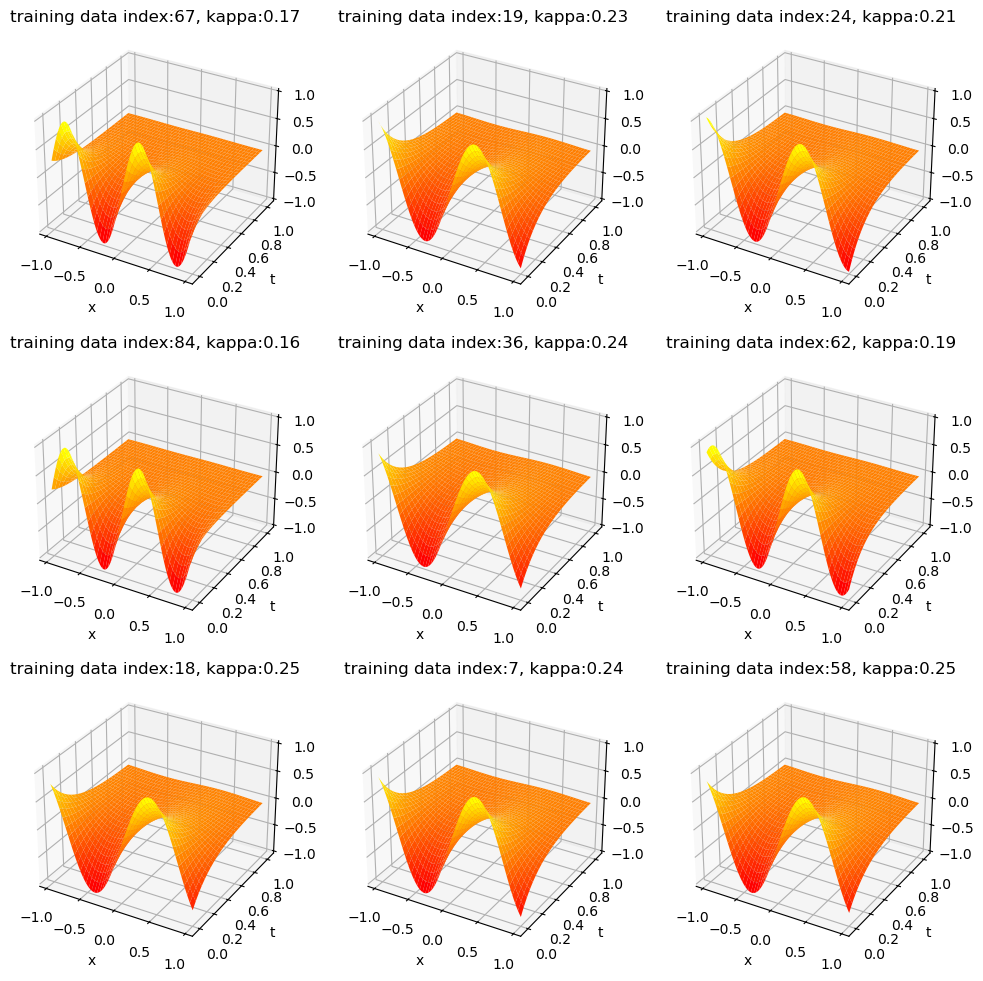

In [24]:
tr_idx_ALL = np.random.permutation(100)
fig, axes = plt.subplots(3, 3, figsize=(12, 12), subplot_kw=dict(projection='3d'))
axe = axes.flatten()
for i in range(len(axe)):
    tr_idx = tr_idx_ALL[i]
    axe[i].plot_surface(xx, tt, trunk_output_data[tr_idx].reshape(num_t,num_x), cmap='autumn', cstride=2, rstride=2)
    axe[i].set_xlabel('x')
    axe[i].set_ylabel('t')
    axe[i].set_xlim([-1.1, 1.1])
    axe[i].set_ylim([-0.1, T_FINAL + 0.1])
    axe[i].set_title(f'training data index:{tr_idx}, kappa:{branch_input_data[tr_idx]:.2f}')

In [25]:
HYPER_OPTIM = {"MAXITER": MAXITER, 
               "NAME": OPTIMIZER_NAME, 
               "LEARNING_RATE_SCHEDULER": LR_SCHEDULER, 
               "LEARNING_RATE_INITIAL": LEARNING_RATE, 
               "LEARNING_RATE_DECAY": LR_DECAY, 
               "LEARNING_RATE_STEP": LR_STEP, 
               "PRINT_EVERY": PRINT_EVERY,
               "LBFGS": {"USE": LBFGS_USE, "MAXITER": LBFGS_MAXITER, "PRINT_EVERY": LBFGS_PRINT_EVERY}
               }

In [26]:
# model_A     = jr.normal(key=subkey_model_A,shape=(DEEPONET_WIDTH+1, num_op_data))
model_A     = jnp.zeros(shape=(DEEPONET_WIDTH+1, 100))
model       = model_trunk, model_A

In [27]:
def loss_fn(model):
    model_trunk, model_A = model
    residual = (jnp.concatenate([vmap(lambda x: model_trunk(x))(trunk_input_data), jnp.ones([trunk_input_data.shape[0],1])],axis=1) @ model_A).T - trunk_output_data
    return jnp.mean(residual**2)

In [28]:
start_time = time.time()
model, log_loss, log_minloss = training_MODEL(model, loss_fn, HYPER_OPTIM)
end_time = time.time()

Selected Optimizer is [ adam ], Initial Learning Rate is 1.00e-03
You are using [ exponential ] learning rate scheduler with rate: 0.90 and step: 1000
-------------------------TRAINING STARTS-------------------------
-----------------------------------------------------------------
Epoch   0K: loss = 6.1332e-02, minloss = 6.1332e-02, Time: 0.27s
Epoch   1K: loss = 3.4324e-05, minloss = 3.4324e-05, Time: 3.80s
Epoch   2K: loss = 1.0157e-05, minloss = 1.0157e-05, Time: 4.38s
Epoch   3K: loss = 4.9552e-06, minloss = 4.9552e-06, Time: 4.21s
Epoch   4K: loss = 3.2231e-06, minloss = 2.9689e-06, Time: 3.62s
Epoch   5K: loss = 1.8982e-06, minloss = 1.8982e-06, Time: 3.58s
Epoch   6K: loss = 2.4098e-06, minloss = 1.3231e-06, Time: 3.73s
Epoch   7K: loss = 9.4706e-07, minloss = 9.4706e-07, Time: 3.70s
Epoch   8K: loss = 7.6156e-07, minloss = 7.4247e-07, Time: 3.68s
Epoch   9K: loss = 1.2787e-06, minloss = 6.1407e-07, Time: 3.70s
Epoch  10K: loss = 5.5323e-07, minloss = 5.3119e-07, Time: 4.14s
--

In [29]:
model_trunk, model_A = model
T_MAT = jnp.concatenate([vmap(lambda x: model_trunk(x))(trunk_input_data), jnp.ones([trunk_input_data.shape[0],1])],axis=1)
import scipy
Q, R  = scipy.linalg.qr(T_MAT, mode='economic')
lsq_A = scipy.linalg.lstsq(T_MAT, trunk_output_data.T)[0]
branch_output_data = R @ lsq_A

In [30]:
model_branch= create_FNN(key=subkey_model_branch, **HYPER_MODEL["BRANCH"])

LEARNING_RATE = 1e-3
OPTIMIZER_NAME = 'adam'
# adabelief, adadelta, adan, adafactor, adagrad, adam, adamw,
# adamax, adamaxw, amsgrad, lion, nadam, nadamw, novograd, radam,
# rmsprop, sgd, sm3, yogi, polyak_sgd
MAXITER = 50_000
PRINT_EVERY = 1_000

LR_SCHEDULER = 'constant' # exponential or constant
LR_DECAY = 0.90
LR_STEP  = 10_000

LBFGS_USE = 'off'
LBFGS_MAXITER = 10_000
LBFGS_PRINT_EVERY = 1_00
if LBFGS_USE != 'on':
    LBFGS_MAXITER = 0
    LBFGS_PRINT_EVERY = 0
    
HYPER_OPTIM_Branch = {"MAXITER": MAXITER, 
               "NAME": OPTIMIZER_NAME, 
               "LEARNING_RATE_SCHEDULER": LR_SCHEDULER, 
               "LEARNING_RATE_INITIAL": LEARNING_RATE, 
               "LEARNING_RATE_DECAY": LR_DECAY, 
               "LEARNING_RATE_STEP": LR_STEP, 
               "PRINT_EVERY": PRINT_EVERY,
               "LBFGS": {"USE": LBFGS_USE, "MAXITER": LBFGS_MAXITER, "PRINT_EVERY": LBFGS_PRINT_EVERY}
               }


In [35]:
def branch_loss_fn(model):
    residual = vmap(model)(branch_input_data[:,None]).T - branch_output_data
    return jnp.mean((residual)**2)

start_time = time.time()
model_branch, log_loss_branch, log_minloss_branch = training_MODEL(model_branch, branch_loss_fn, HYPER_OPTIM_Branch)
end_time = time.time()

Selected Optimizer is [ adam ], Initial Learning Rate is 1.00e-03
You are using [ constant ] learning rate
-------------------------TRAINING STARTS-------------------------
-----------------------------------------------------------------
Epoch   0K: loss = 6.3431e+00, minloss = 6.3431e+00, Time: 0.21s
Epoch   1K: loss = 1.5534e+00, minloss = 1.5534e+00, Time: 0.36s
Epoch   2K: loss = 6.2629e-03, minloss = 6.2629e-03, Time: 0.36s
Epoch   3K: loss = 1.5956e-04, minloss = 1.5956e-04, Time: 0.36s
Epoch   4K: loss = 5.2943e-05, minloss = 5.2943e-05, Time: 0.37s
Epoch   5K: loss = 3.9844e-05, minloss = 2.3294e-05, Time: 0.37s
Epoch   6K: loss = 4.9213e-05, minloss = 1.0319e-05, Time: 0.38s
Epoch   7K: loss = 2.7497e-04, minloss = 4.9601e-06, Time: 0.36s
Epoch   8K: loss = 3.8780e-06, minloss = 3.0730e-06, Time: 0.38s
Epoch   9K: loss = 2.3444e-06, minloss = 2.2688e-06, Time: 0.37s
Epoch  10K: loss = 2.3798e-06, minloss = 1.7729e-06, Time: 0.41s
Epoch  11K: loss = 1.7760e-06, minloss = 1.514

In [45]:
T_MAT = jnp.concatenate([vmap(lambda x: model_trunk(x))(trunk_input_test), jnp.ones([trunk_input_test.shape[0],1])],axis=1)
Q_tt = scipy.linalg.lstsq(R.T, T_MAT.T)[0].T
NN_pred_final = (Q_tt @ (vmap(model_branch)(branch_input_test[:,None]).T)).T

Avg. Relative L2 error     : 1.0980e-03


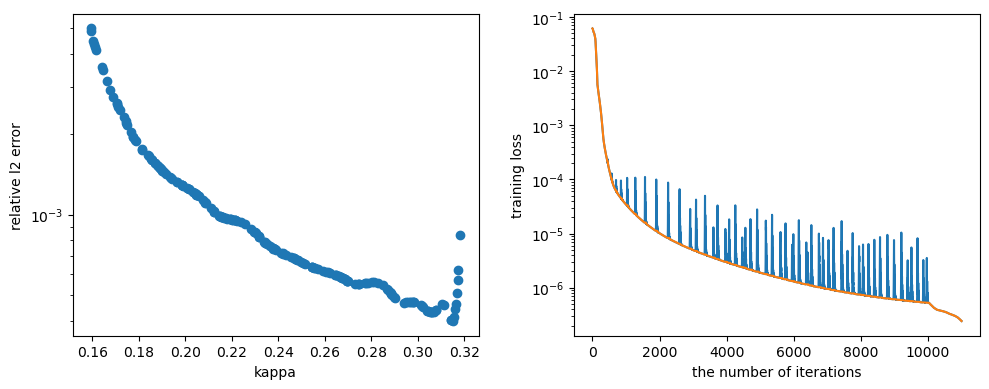

In [46]:
rel_l2_error = jnp.sqrt(jnp.sum((trunk_output_test - NN_pred_final)**2,axis=1) / jnp.sum(trunk_output_test**2,axis=1))
print(f"Avg. Relative L2 error     : {jnp.mean(rel_l2_error):.4e}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(branch_input_test,rel_l2_error)
axes[0].set_yscale('log')
axes[0].set_xlabel('kappa')
axes[0].set_ylabel('relative l2 error')
axes[1].semilogy(log_loss)
axes[1].semilogy(log_minloss)
axes[1].set_xlabel('the number of iterations')
axes[1].set_ylabel('training loss')
plt.tight_layout()
# plt.suptitle(title_str + '\n')
plt.show()

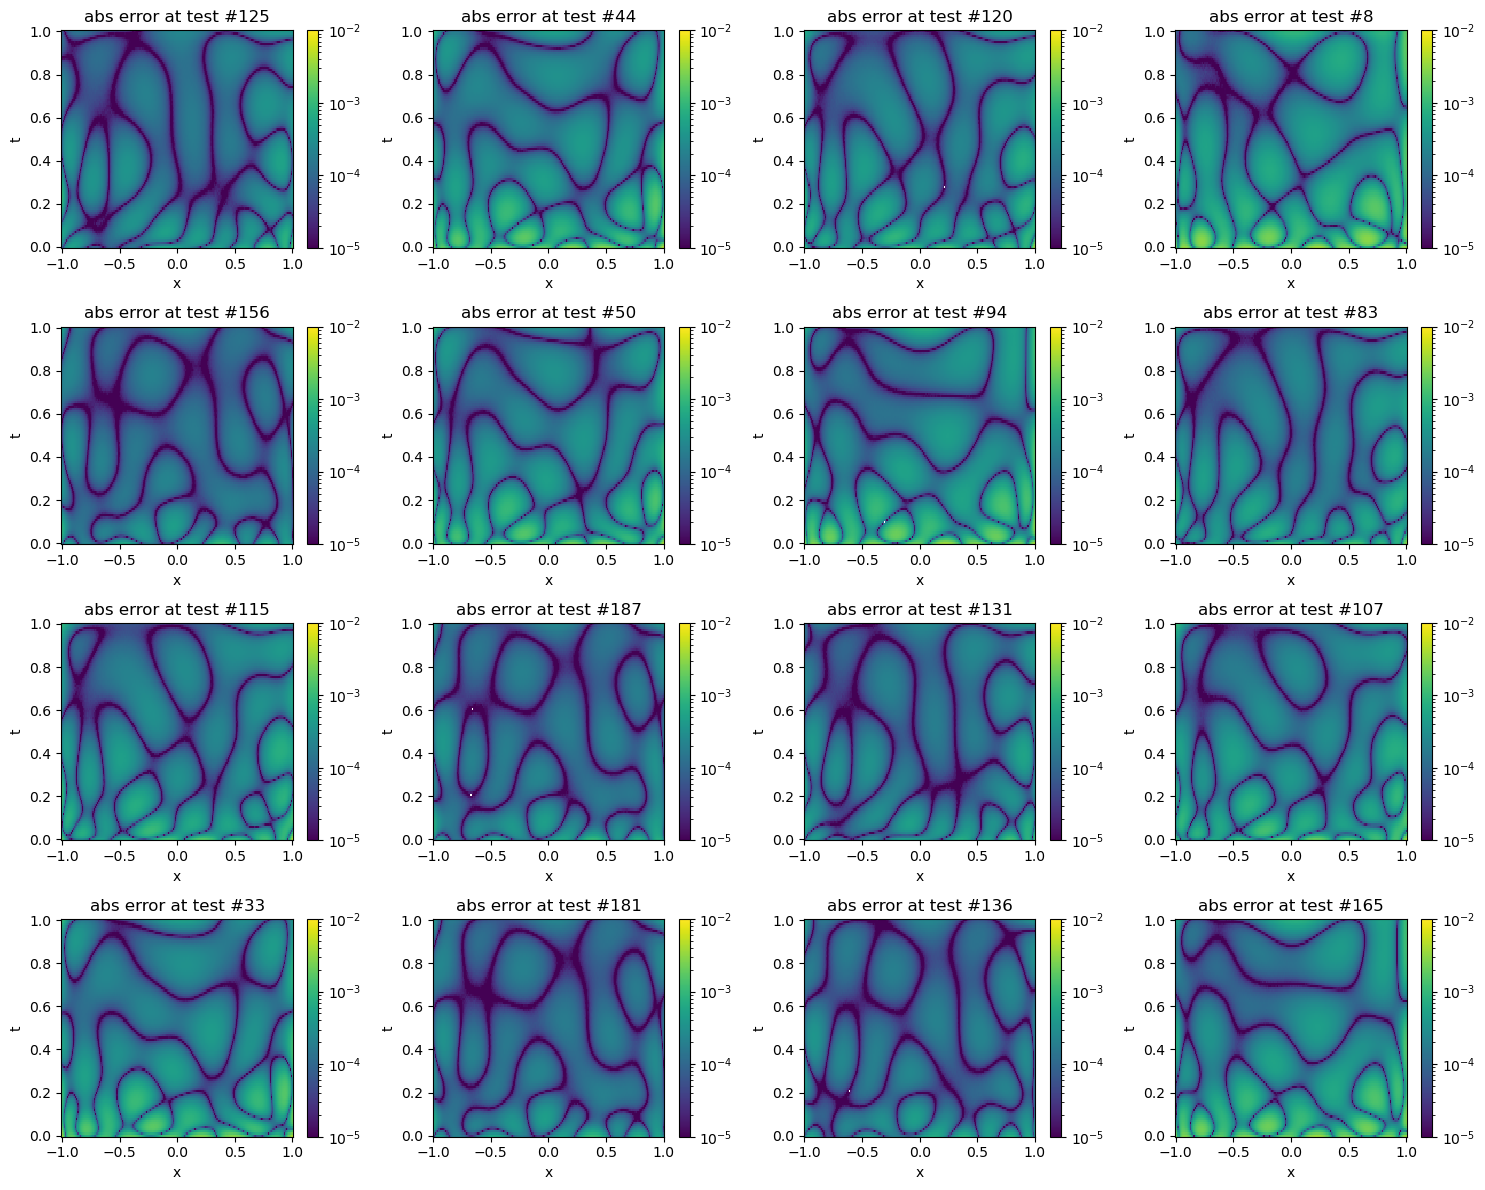

In [47]:
rnd_idx = np.random.permutation(200)
fig, axes = plt.subplots(4, 4, figsize=(15, 12))
axe = axes.flatten()
for i in range(len(axe)):
    tt_idx = rnd_idx[i]
    pcm = axe[i].pcolormesh(xx_tt, tt_tt, jnp.abs((NN_pred_final[tt_idx]-trunk_output_test[tt_idx]).reshape(xx_tt.shape)),norm="log",cmap='viridis', vmin=1e-5, vmax=1e-2)
    axe[i].set_title(f'abs error at test #{tt_idx+1}')
    axe[i].set_xlabel('x')
    axe[i].set_ylabel('t')
    fig.colorbar(pcm, ax=axe[i])
fig.tight_layout()

In [ ]:
# save_MODEL('DeepONet_HeatEqn.eqx',HYPER_MODEL,model)

In [ ]:
# loaded_model = load_DeepONet('DeepONet_Diff.eqx')